<a href="https://colab.research.google.com/github/ulissigroup/amptorch/blob/active_learning/AL_relaxation_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install  -q git+https://github.com/ulissigroup/amptorch.git@active_learning
!pip install -q git+https://github.com/mshuaibii/SIMPLE-NN.git
!pip install -q amp-atomistics
!pip install -q --upgrade dftbook

     |████████████████████████████████| 296kB 2.8MB/s 
     |████████████████████████████████| 6.7MB 48.4MB/s 
     |████████████████████████████████| 102kB 11.9MB/s 
     |████████████████████████████████| 2.1MB 46.1MB/s 
     |████████████████████████████████| 12.8MB 4.0MB/s 
     |████████████████████████████████| 110.5MB 47kB/s 
     |████████████████████████████████| 3.8MB 36.3MB/s 
     |████████████████████████████████| 512kB 50.8MB/s 
  ERROR: Failed building wheel for simple-nn
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
    Running setup.py install for simple-nn ... done
     |████████████████████████████████| 102kB 2.4MB/s 


In [0]:
import numpy as np
import random

import torch

import ase
from ase.calculators.calculator import Calculator
from ase.calculators.emt import EMT
from ase.calculators.singlepoint import SinglePointCalculator as sp
from ase.build import fcc100, add_adsorbate, molecule
from ase.constraints import FixAtoms
from ase.optimize import BFGS

from amptorch.active_learning.generator_funcs import MDsimulate, Relaxation
from amptorch.active_learning.al_calc import AtomisticActiveLearning
from amptorch.model import CustomMSELoss

In [12]:
random.seed(0)
# Define initial set of images, can be as few as 1. If 1, make sure to change train_split to 0.

slab = fcc100("Cu", size=(3, 3, 3))
ads = molecule("C")
add_adsorbate(slab, ads, 3, offset=(1, 1))
cons = FixAtoms(
    indices=[atom.index for atom in slab if (atom.tag == 3)]
)
slab.set_constraint(cons)
slab.center(vacuum=13.0, axis=2)
slab.set_pbc(True)
slab.wrap(pbc=[True] * 3)
slab.set_calculator(EMT())

images = [slab]

# Define symmetry functions
Gs = {}
Gs["G2_etas"] = np.logspace(np.log10(0.05), np.log10(5.0), num=4)
Gs["G2_rs_s"] = [0] * 4
Gs["G4_etas"] = [0.005]
Gs["G4_zetas"] = [1.0, 4.0]
Gs["G4_gammas"] = [+1.0, -1]
Gs["cutoff"] = 5.876798323827276  # EMT asap_cutoff: False

# Define morse parameters if Delta-ML model, o/w morse = False
morse_params = {
    "C": {"re": 0.972, "D": 6.379, "sig": 0.477},
    "Cu": {"re": 2.168, "D": 3.8386, "sig": 1.696},
}

training_params = {
      "al_convergence": {"method": "iter", "num_iterations": 3},
      "samples_to_retrain": 3,
      "Gs": Gs,
      "morse": True,
      "morse_params": morse_params,
      "forcetraining": True,
      "cores": 10,
      "optimizer": torch.optim.LBFGS,
      "batch_size": 1000,
      "criterion": CustomMSELoss,
      "num_layers": 3,
      "num_nodes": 20,
      "force_coefficient": 0.04,
      "learning_rate": 1e-1,
      "epochs": 100,
      "test_split": 0.3,
      "shuffle": False
}

# Define AL calculator
al_calc = AtomisticActiveLearning(
    parent_calc=EMT(), images=images, filename="relax_example",
    file_dir="./"
)
# Define AL generating function and training scheme.
al_calc.active_learner(
    generating_function=Relaxation(
        initial_geometry=images[0].copy(),
        optimizer=BFGS,
        fmax=0.05,
        steps=50,
    ),
    training_params=training_params
)

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.1168          5.5699        0.6273     +  0.1107
      2          0.0036          0.3230        0.0021     +  0.1231
      3          0.0004          0.0943        0.0002     +  0.1449
      4          0.0001          0.0576        0.0001     +  0.1563
      5          0.0000          0.0297        0.0000     +  0.1628
      6          0.0000          0.0170        0.0000     +  0.1812
      7          0.0000          0.0106        0.0000     +  0.1801
      8          0.0000          0.0091        0.0000     +  0.1987
      9          0.0000          0.0080        0.0000     +  0.1914
     10          0.0000          0.0077        0.0000     +  0.1729
     11          0.0000          0.0072        0.0000     +  0.1664
     12          0.0000          0.0062        0.0000     +  0.

In [13]:
# Compute the parent calculator (DFT, etc. - EMT in this case) based relaxation

true_relax = Relaxation(slab, BFGS)
true_relax.run(EMT(), 'true_relax')
emt_relax = true_relax.get_trajectory('true_relax', 0, -1, 1)

      Step     Time          Energy         fmax
BFGS:    0 19:06:20       10.682420        1.2934
BFGS:    1 19:06:20       10.643511        1.3420
BFGS:    2 19:06:20       10.557724        1.4494
BFGS:    3 19:06:20       10.468315        1.5602
BFGS:    4 19:06:20       10.374426        1.6737
BFGS:    5 19:06:20       10.275453        1.7887
BFGS:    6 19:06:20       10.170987        1.9040
BFGS:    7 19:06:20       10.060796        2.0177
BFGS:    8 19:06:20        9.944839        2.1271
BFGS:    9 19:06:21        9.823303        2.2289
BFGS:   10 19:06:21        9.696655        2.3189
BFGS:   11 19:06:21        9.565718        2.3915
BFGS:   12 19:06:21        9.431758        2.4398
BFGS:   13 19:06:21        9.296585        2.4554
BFGS:   14 19:06:21        9.162670        2.4278
BFGS:   15 19:06:21        9.033283        2.3450
BFGS:   16 19:06:21        8.912544        2.1933
BFGS:   17 19:06:21        8.805366        1.9585
BFGS:   18 19:06:21        8.717146        1.6289
B

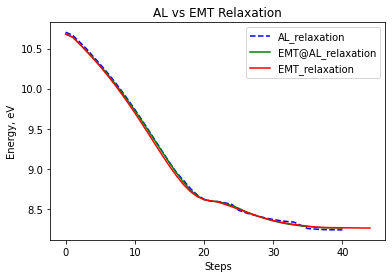

In [14]:
# Visualize Results
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline

final_ml_traj = ase.io.read("./relax_example_iter_3.traj", ":")
parent_calc_traj = ase.io.read("./true_relax.traj", ":")

#Compute ML predicted energies
ml_relaxation_energies = [image.get_potential_energy() for image in final_ml_traj]
#Compute actual (EMT) energies for ML predicted structures
emt_evaluated_ml_energies = [EMT().get_potential_energy(image) for image in final_ml_traj]
#Compute actual energies for EMT relaxation structures
emt_relaxation_energies = [image.get_potential_energy() for image in parent_calc_traj]
ml_steps = range(len(final_ml_traj))
emt_steps = range(len(parent_calc_traj))

plt.plot(ml_steps, ml_relaxation_energies, '--b', label='AL_relaxation')
plt.plot(ml_steps, emt_evaluated_ml_energies, '-g', label='EMT@AL_relaxation')
plt.plot(emt_steps, emt_relaxation_energies, '-r', label='EMT_relaxation')
plt.xlabel("Steps")
plt.ylabel("Energy, eV")
plt.title('AL vs EMT Relaxation')
plt.legend()
plt.show()

In [16]:
# Evaluation Metrics
def compute_loss(a, b):
  return np.mean(np.sqrt(np.sum((a - b)**2, axis=1)))

initial_structure = images[0].positions
print('Number of AL iterations: 3\nNumber of samples/iteration: 3\nTotal # of queries (EMT calls): 9 \n')
print(f'Final AL Relaxed Energy: {ml_relaxation_energies[-1]}')
print(f'EMT evaluation at AL structure: {EMT().get_potential_energy(final_ml_traj[-1])}\n')
al_relaxed_structure = final_ml_traj[-1].positions

print(f'Total number of EMT steps: {len(emt_relaxation_energies)}')
print(f'Final EMT Relaxed Energy: {emt_relaxation_energies[-1]}\n')
emt_relaxed_structure = parent_calc_traj[-1].positions


initial_structure_error = compute_loss(initial_structure, emt_relaxed_structure)
relaxed_structure_error = compute_loss(al_relaxed_structure, emt_relaxed_structure)

print(f'Initial structure error: {initial_structure_error}')
print(f'AL relaxed structure error: {relaxed_structure_error}')

Number of AL iterations: 3
Number of samples/iteration: 3
Total # of queries (EMT calls): 9 

Final AL Relaxed Energy: 8.235238075256348
EMT evaluation at AL structure: 8.2601219721632

Total number of EMT steps: 45
Final EMT Relaxed Energy: 8.259098714525155

Initial structure error: 0.0725933325822735
AL relaxed structure error: 0.0048840685834223765
